In [1]:
!curl -L -o dataset_imun.h5ad https://datasets.cellxgene.cziscience.com/e8ab8e6c-9a29-480b-9732-bf692c762716.h5ad


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 5315M    0  711k    0     0   414k      0  3:38:46  0:00:01  3:38:45  414k
  0 5315M    0 7472k    0     0  2752k      0  0:32:57  0:00:02  0:32:55 2753k
  0 5315M    0 12.5M    0     0  3468k      0  0:26:09  0:00:03  0:26:06 3469k
  0 5315M    0 19.8M    0     0  4326k      0  0:20:57  0:00:04  0:20:53 4327k
  0 5315M    0 29.0M    0     0  5223k      0  0:17:21  0:00:05  0:17:16 6309k
  0 5315M    0 39.5M    0     0  6048k      0  0:14:59  0:00:06  0:14:53 7987k
  0 5315M    0 49.7M    0     0  6618k      0  0:13:42  0:00:07  0:13:35 8720k
  1 5315M    1 60.1M    0     0  7077k      0  0:12:49  0:00:08  0:12:41 9750k
  1 5315M    1 70.8M    0     0  7479k      0  0:12

In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
from anndata import AnnData
import partipy as pt


# Verbosity parameter shows amount of
# logging you will see during functions' execution
sc.settings.verbosity = 3

# Reading of the dataset

adata = sc.read_h5ad("dataset_imun.h5ad")
adata


AnnData object with n_obs × n_vars = 743615 × 32357
    obs: 'cohort.cohortGuid', 'sample.sampleKitGuid', 'specimen.specimenGuid', 'pipeline.fileGuid', 'subject.birthYear', 'subject.ageAtFirstDraw', 'subject.ageGroup', 'subject.race', 'subject.ethnicity', 'subject.cmv', 'subject.bmi', 'sample.visitName', 'sample.drawYear', 'sample.subjectAgeAtDraw', 'batch_id', 'pool_id', 'chip_id', 'well_id', 'original_barcodes', 'cell_name', 'n_reads', 'n_umis', 'n_genes', 'total_counts_mito', 'pct_counts_mito', 'doublet_score', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'tissue_type', 'suspension_type', 'assay_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'cell_type_ontology_term_id', 'is_primary_data', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'mito', 'n_cells_by_counts', 'mean_co

In [ ]:
X = adata.X


print("Shape:", X.shape)
print("Mean:", X.mean())
print("Median:", np.median(X))
print("Std:", X.std())
print("Min:", X.min())
print("Max:", X.max())


Shape: (743615, 32357)
Mean: 0.066138215


ValueError: setting an array element with a sequence.

In [4]:
obs_keep = [ "donor_id", "sample", "tissue", "tissue_type", "cell_type", "author_cell_type", "sex", "development_stage", "disease", "Time", "donor_time" ]

var_keep = [ "gene_symbols", "feature_name", "feature_biotype", "feature_length" ]

obs_keep = [c for c in obs_keep if c in adata.obs.columns]

obs = adata.obs[obs_keep].copy()

var_keep = [c for c in var_keep if c in adata.var.columns]

var = adata.var[var_keep].copy()

adata_new = AnnData(
    X=adata.X,   # лучше использовать исходное adata.X
    obs=obs,
    var=var
)


adata_new



AnnData object with n_obs × n_vars = 743615 × 32357
    obs: 'donor_id', 'tissue', 'tissue_type', 'cell_type', 'sex', 'development_stage', 'disease'
    var: 'gene_symbols', 'feature_name', 'feature_biotype', 'feature_length'

In [5]:
# создаём словарь ENSG -> gene_symbol
gene_map = (
    adata_new.var
    .reset_index()
    .set_index("index")["gene_symbols"]
    .dropna()
    .to_dict()
)

# заменяем имена в индексе var
adata_new.var.index = adata_new.var.index.to_series().replace(gene_map)

adata_new.var


,gene_symbols,feature_name,feature_biotype,feature_length
MIR1302-2HG,MIR1302-2HG,MIR1302-2HG,gene,517
FAM138A,FAM138A,FAM138A,gene,1015
OR4F5,OR4F5,OR4F5,gene,2618
AL627309.3,AL627309.3,ENSG00000239945,gene,1319
AL627309.2,AL627309.2,ENSG00000239906,gene,323
...,...,...,...,...
AC233755.2,AC233755.2,ENSG00000277856,gene,294
AC233755.1,AC233755.1,ENSG00000275063,gene,351
AC240274.1,AC240274.1,ENSG00000271254,gene,2922
AC213203.1,AC213203.1,ENSG00000277475,gene,831


In [6]:
adata_new.var["mt"] = adata_new.var_names.str.upper().str.startswith("MT-")

sc.pp.calculate_qc_metrics(
    adata_new,
    qc_vars=["mt"],
    percent_top=None,
    inplace=True,
    log1p=False,
)
adata_new.obs["pct_counts_mt"].describe()

count    743615.000000
mean          1.445680
std           0.307267
min           0.000000
25%           1.252550
50%           1.434470
75%           1.621923
max           9.341057
Name: pct_counts_mt, dtype: float64

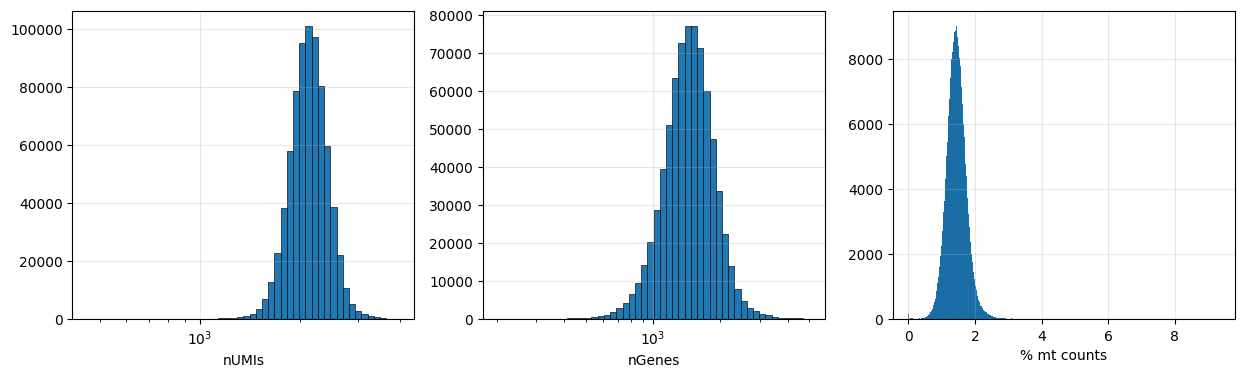

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

sns.histplot(adata_new.obs.total_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[0])
axes[0].set_ylabel("")
axes[0].set_xlabel("nUMIs")
axes[0].grid(alpha=0.3)

sns.histplot(adata_new.obs.n_genes_by_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[1])
axes[1].set_ylabel("")
axes[1].set_xlabel("nGenes")
axes[1].grid(alpha=0.3)

sns.histplot(adata_new.obs.pct_counts_mt, alpha=1, edgecolor="black", ax=axes[2])
axes[2].set_ylabel("")
axes[2].set_xlabel("% mt counts")
axes[2].grid(alpha=0.3)

In [8]:
adata_clear = adata_new[
    (adata_new.obs["total_counts"] > 1000) &
    (adata_new.obs["total_counts"] < 3000) &
    (adata_new.obs["n_genes_by_counts"] > 600) &
    (adata_new.obs["n_genes_by_counts"] < 3000)
].copy()


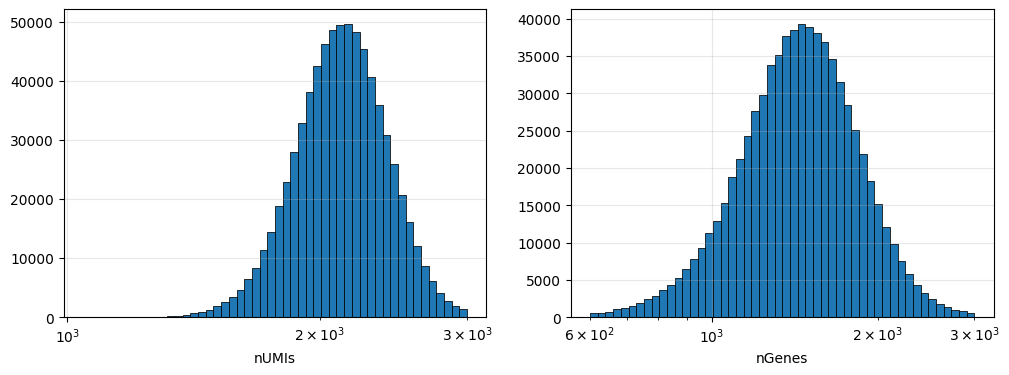

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

sns.histplot(adata_clear.obs.total_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[0])
axes[0].set_ylabel("")
axes[0].set_xlabel("nUMIs")
axes[0].grid(alpha=0.3)

sns.histplot(adata_clear.obs.n_genes_by_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[1])
axes[1].set_ylabel("")
axes[1].set_xlabel("nGenes")
axes[1].grid(alpha=0.3)

In [10]:
print(set(adata_clear.obs["cell_type"]))

{'memory CCR4-positive regulatory T cell', 'memory regulatory T cell', 'CD4-positive, alpha-beta memory T cell', 'naive regulatory T cell', 'double negative thymocyte', 'effector memory CD4-positive, alpha-beta T cell', 'CD8-positive, alpha-beta regulatory T cell', 'T cell', 'naive thymus-derived CD4-positive, alpha-beta T cell', 'central memory CD4-positive, alpha-beta T cell'}


In [12]:
adata_blood = adata_clear

print("Shape:", adata.shape)
print("Shape:", adata_blood.shape)

Shape: (743615, 32357)
Shape: (734491, 32357)


In [27]:

adata_blood.raw = adata_blood.copy()
print(adata_blood.n_obs, adata_blood.n_vars)


sc.pp.scrublet(adata_blood, batch_key="donor_id")


734491 22876
Running Scrublet
filtered out 7347 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    using data matrix X directly
Automatically set threshold at doublet score = 0.56
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 11.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.6%
filtered out 6760 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float 

In [28]:
sc.pp.filter_genes(adata_blood, min_cells=10)


MemoryError: Unable to allocate 4.04 GiB for an array with shape (1083436518,) and data type float32

In [ ]:
sc.pp.normalize_total(adata_blood, target_sum=1e4)
sc.pp.log1p(adata_blood)


normalizing counts per cell
    finished (0:00:59)


In [ ]:
sc.pp.highly_variable_genes(adata_blood, n_top_genes=1000, batch_key="donor_id")
adata_blood = adata_blood[:, adata_blood.var['highly_variable']]



extracting highly variable genes
    finished (0:01:30)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [ ]:
sc.pp.scale(adata_blood, max_value=10)
sc.pp.pca(adata_blood, n_comps=30)


c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\scanpy\preprocessing\_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.


computing PCA
    with n_comps=30
    finished (0:04:36)


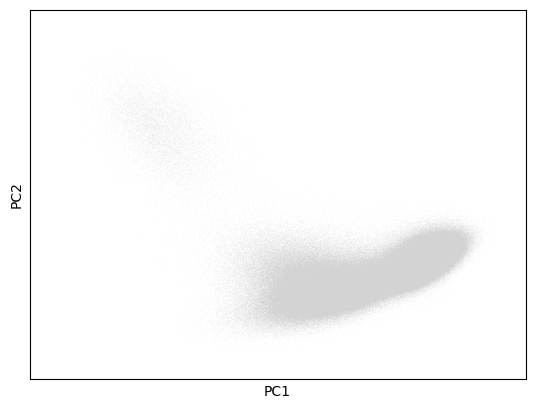

In [ ]:
adata_blood.layers["z_scaled"]= sc.pp.scale(adata_blood.X, max_value=10, copy=True)
sc.pl.pca_scatter(adata_blood)